In [3]:
import utils as local_utils
import torch
import torch.nn as nn
#import pytorch_utils
import torch.optim as optim
import torch.optim as optim
import torch.utils.data as DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import sys
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from importlib import reload
import torch.nn.functional as F
from torchvision import transforms, utils, models
import os, sys
from random import shuffle

%matplotlib inline

In [4]:
USE_GPU = True
IMG_SZ = 224

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Custom dataset

In [5]:
class LandmarksDataset(DataLoader.Dataset):

    def __init__(self, src_folder, transform=None):
        """
        Args:
            src_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filenames = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                          and f != '.DS_Store']
        self.src_folder = src_folder
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.src_folder, self.filenames[idx])
        
        x = Image.open(img_name)

        if self.transform:
            x = self.transform(x)

        imgf = self.filenames[idx]
        y = int(imgf[imgf.index('_') + 1 : imgf.index('.')]) # filename format: [id_label.jpg]
        sample = (x, y)
        return sample

In [6]:
def get_loader(directory, batch_size):
    '''
    takes in directory for train and val data, and returns loaders for both
    applies normalization:
      1. convert values to range 0-1
      2. set mean, std to those specified in pytorch pretrained models (https://pytorch.org/docs/master/torchvision/models.html)
    
    usage:
        loader_train = get_loader(train_directory, batch_sz)
        loader_val = get_loader(val_directory, batch_sz)
    '''
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

    preprocess = transforms.Compose([
       transforms.ToTensor(),  # converts to range 0-1
       normalize               # sets mean, std
    ])
    
    dset = LandmarksDataset(directory, transform=preprocess)
    loader = DataLoader.DataLoader(dataset=dset, batch_size=batch_size)
    
    print ('dataset size', len(dset))
    return loader

## Training and accuracy checking

In [7]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [8]:
def train(model, optimizer, loader_train, epochs=1, stop=1):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iters = []
    losses = []
    for e in range(epochs):
        print ('epoch', e)
        
        num_iters = len(loader_train)
        want_print = 10
        print_every = 50
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
        
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(' Iteration %d out of %d, loss = %.4f' % (t, num_iters, loss.item()))
                iters.append(t)
                losses.append(loss.item())
            
            # break early if we only want to use a part of the dataset (for hyperparameter tuning)
            if t > stop * num_iters:
                break

    return iters, losses

## Plotting

In [36]:
def plot_loss_data(plotting_data, title_str):
    '''
    Plots loss vs. iterations for the various hyperparameter runs
    '''
    for plot_data in plotting_data:
        iters, losses, label = plot_data        
        plt.plot(iters, losses, label=label)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc=(1.4, 0.25))
    
    # set figsize
    plt.rcParams["figure.figsize"] = (20, 15)
    
    plt.plot()

# Models!

### Resnet

In [ ]:
# referenced https://www.kaggle.com/gntoni/using-pytorch-resnet

# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up resnet model with custom FC layer to predict our number of classes
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
            
print("best values ", best_loss, best_lr, best_batch_size)

Check accuracies

In [ ]:
loader_val = get_loader(val_directory, best_batch_size)
print ('validation accuracy is ', check_accuracy(loader_val, best_model))
loader_train = get_loader(train_directory, best_batch_size)
print ('training accuracy is ', check_accuracy(loader_train, best_model))

Plot loss curves

In [ ]:
plot_data(plotting_data, title_str="Hyperparameter tuning for Resnet18")

### Squeezenet

In [10]:
# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

#train_directory = '../data/data_200c/train'
#val_directory = '../data/data_200c/val'
train_directory = '../data/data_200c/mini'
val_directory = '../data/data_200c/mini'

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up squeezenet model with custom final conv layer to predict our number of classes
        model = models.squeezenet1_0(pretrained=True)
        final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        model.classifier = nn.Sequential(
                    nn.Dropout(p=0.5),
                    final_conv,
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(13))
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
print (' ')          
print("best loss: ", best_loss, 'best lr', best_lr, 'best batch sz', best_batch_size)

dataset size 8
epoch 0


/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


 Iteration 0 out of 1, loss = 5.6461
got a loss of  5.6461358070373535  for parameters  batch size:  10  lr:  0.0001
epoch 0
 Iteration 0 out of 1, loss = 6.1103
got a loss of  6.110317230224609  for parameters  batch size:  10  lr:  0.001
epoch 0
 Iteration 0 out of 1, loss = 6.3672
got a loss of  6.367238521575928  for parameters  batch size:  10  lr:  0.01
dataset size 8
epoch 0
 Iteration 0 out of 1, loss = 6.4443
got a loss of  6.444299221038818  for parameters  batch size:  20  lr:  0.0001
epoch 0
 Iteration 0 out of 1, loss = 5.6415
got a loss of  5.64151668548584  for parameters  batch size:  20  lr:  0.001
epoch 0
 Iteration 0 out of 1, loss = 6.2063
got a loss of  6.206313133239746  for parameters  batch size:  20  lr:  0.01
dataset size 8
epoch 0
 Iteration 0 out of 1, loss = 5.9762
got a loss of  5.976180076599121  for parameters  batch size:  50  lr:  0.0001
epoch 0
 Iteration 0 out of 1, loss = 6.1902
got a loss of  6.190211296081543  for parameters  batch size:  50  lr: 

Check accuracies

In [11]:
loader_val = get_loader(val_directory, best_batch_size)
loader_train = get_loader(train_directory, best_batch_size)
print ('validation accuracy is ', check_accuracy(loader_val, best_model))
print ('training accuracy is ', check_accuracy(loader_train, best_model))

dataset size 8
dataset size 8
Got 1 / 8 correct (12.50)
validation accuracy is  0.125
Got 1 / 8 correct (12.50)
training accuracy is  0.125


Plot loss curves

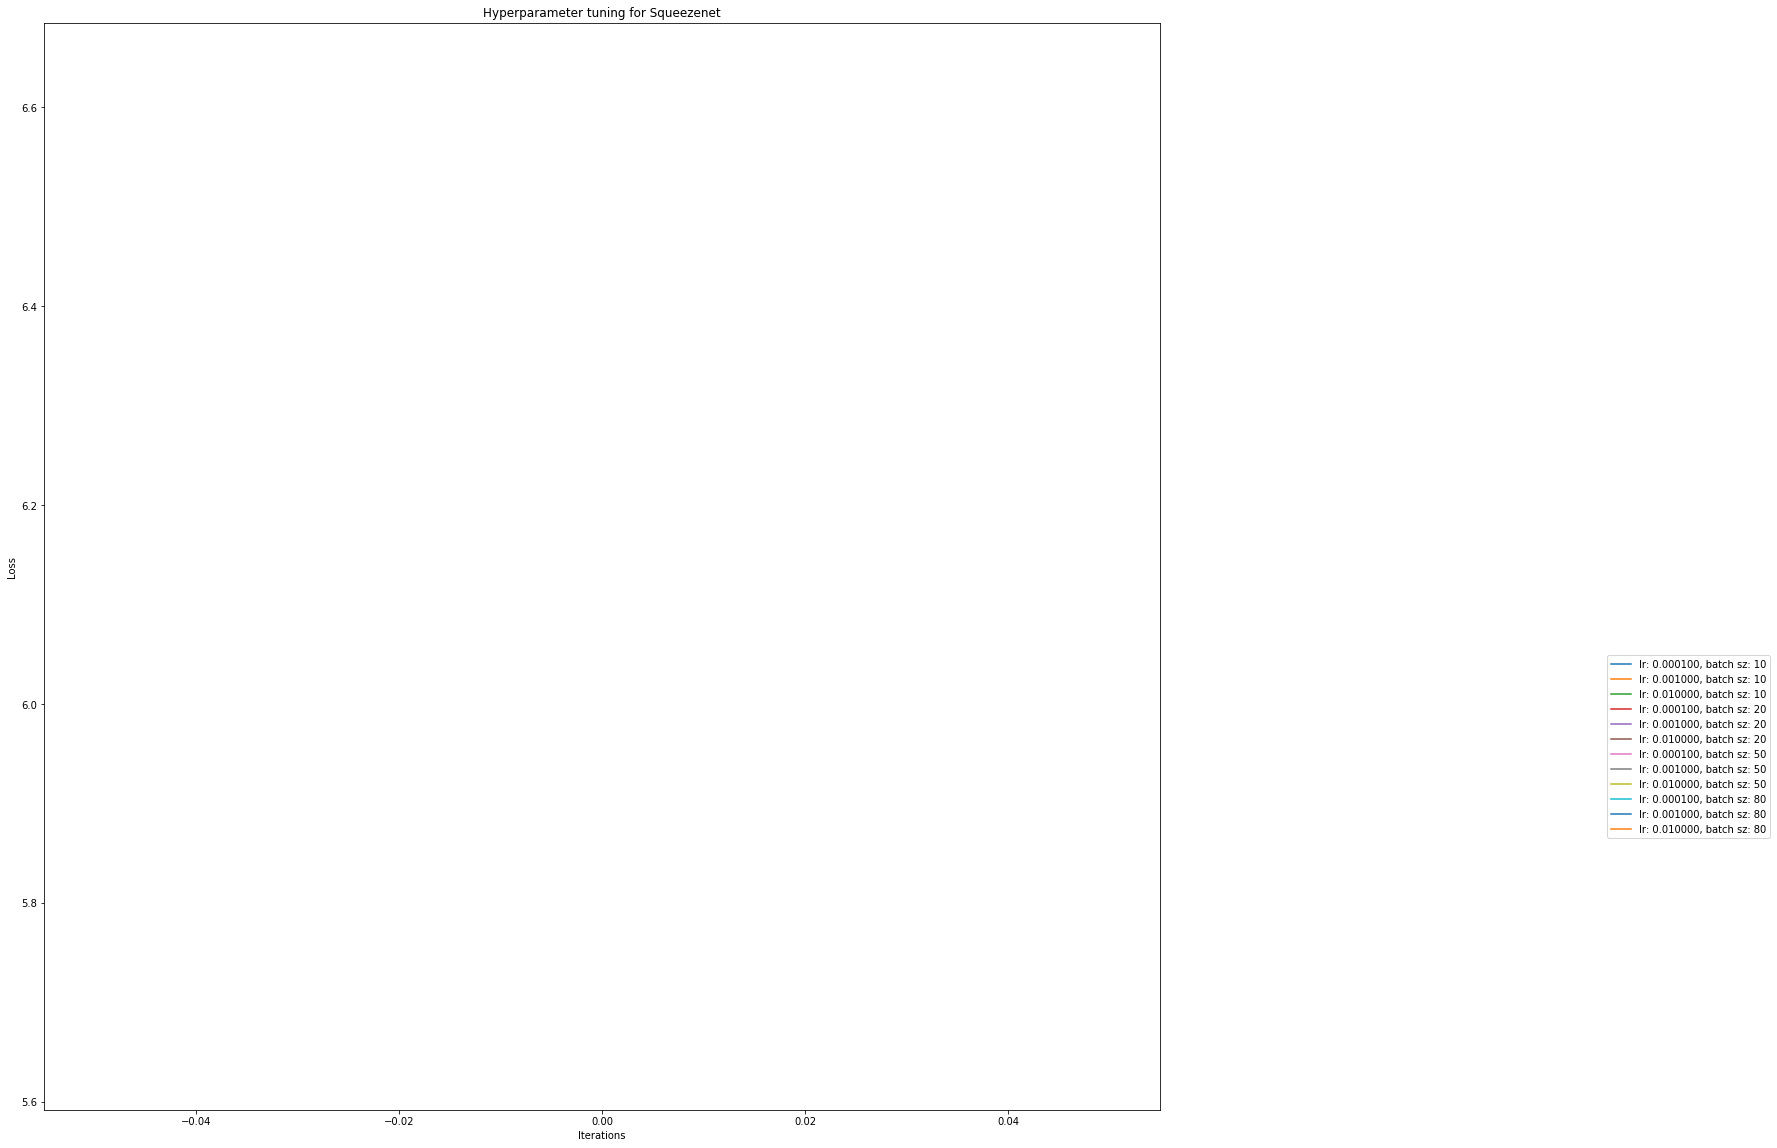

In [37]:
plot_loss_data(plotting_data, title_str="Hyperparameter tuning for Squeezenet")